## **Hand Writting Recongnition Using PyTorch**


In [1]:
import pandas as pd
import numpy as np
#TensorDataset
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.utils import make_grid
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_set = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform = transforms.ToTensor()
)
test_set = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform = transforms.ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
train_ds, val_ds = random_split(train_set, [50000, 10000])
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size*2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size*2)

In [4]:
class MnistModel(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 64)
    self.linear2 = nn.Linear(64, 32)              #Hidden Layer
    self.linear3 = nn.Linear(32, 16)              #Hidden Layer
    self.linear4 = nn.Linear(16, output_size)
  
  def forward(self, x_batch):
    outputs = x_batch.reshape(-1, 784)
    outputs = self.linear4(F.relu(self.linear3(F.relu(self.linear2(F.relu(self.linear1(outputs)))))))
    return outputs

In [5]:
def accuracy_score(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  correct_preds = torch.sum(preds==labels).item()
  total_preds = len(preds)
  accuracy = torch.tensor(correct_preds/total_preds)
  return accuracy

In [6]:
def validation_step(model, batch): 
  images, labels = batch
  loss = F.cross_entropy(model.forward(images), labels)
  acc = accuracy_score(model.forward(images), labels)
  return {'val_loss':loss, 'val_acc':acc}

def validation_epoch_end(outputs):
  batch_losses = [x['val_loss'] for x in outputs]
  epoch_loss = torch.stack(batch_losses).mean()
  batch_accs = [x['val_acc'] for x in outputs]
  epoch_acc = torch.stack(batch_accs).mean()
  return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

def evaluate(model, val_loader):
  metrics = [validation_step(model, batch) for batch in val_loader]
  metrics = validation_epoch_end(metrics)
  return metrics

In [7]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  accuracy = []
  val_accuracy = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:
      images, labels = batch
      loss = F.cross_entropy(model.forward(images), labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    metrics = evaluate(model, train_loader)
    metrics2 = evaluate(model, test_loader)
    print("Epoch: {}/{} ".format(epoch + 1, epochs), '|', 'Training accuracy:', round(metrics['val_acc'], 3), '|', 'Validation accuracy:', round(metrics2['val_acc'], 3))
    accuracy.append(metrics['val_acc'])
    val_accuracy.append(metrics2['val_acc'])  
  
  return accuracy, val_accuracy

In [8]:
max_epochs = 21             #Run for a maximum of 20 epochs

import time
time_list = []              #Contains time taken to execute Neural Network of n epochs
accuracy = []               #Contains Training accuracy of the neural network
val_accuracy = []           #Contains Validation accuracy of the neural network

model = MnistModel(784,10)

for epoch in range(1,max_epochs):
  start = time.time()
  history = fit(epoch, 0.4, model, train_loader, val_loader)
  end = time.time()
  time_list.append(end-start)
  accuracy.append( sum(history[0]) / len(history[0]) )
  val_accuracy.append( sum(history[1]) / len(history[1]) )

Epoch: 1/1  | Training accuracy: 0.934 | Validation accuracy: 0.931
Epoch: 1/2  | Training accuracy: 0.957 | Validation accuracy: 0.953
Epoch: 2/2  | Training accuracy: 0.963 | Validation accuracy: 0.955
Epoch: 1/3  | Training accuracy: 0.977 | Validation accuracy: 0.966
Epoch: 2/3  | Training accuracy: 0.974 | Validation accuracy: 0.966
Epoch: 3/3  | Training accuracy: 0.981 | Validation accuracy: 0.968
Epoch: 1/4  | Training accuracy: 0.981 | Validation accuracy: 0.972
Epoch: 2/4  | Training accuracy: 0.978 | Validation accuracy: 0.966
Epoch: 3/4  | Training accuracy: 0.986 | Validation accuracy: 0.97
Epoch: 4/4  | Training accuracy: 0.979 | Validation accuracy: 0.966
Epoch: 1/5  | Training accuracy: 0.99 | Validation accuracy: 0.974
Epoch: 2/5  | Training accuracy: 0.991 | Validation accuracy: 0.975
Epoch: 3/5  | Training accuracy: 0.989 | Validation accuracy: 0.971
Epoch: 4/5  | Training accuracy: 0.976 | Validation accuracy: 0.958
Epoch: 5/5  | Training accuracy: 0.992 | Validatio

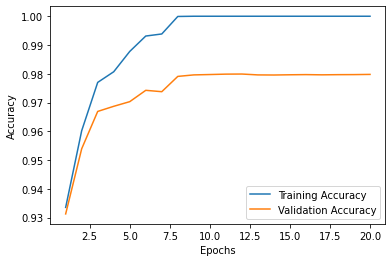

In [9]:
#Plot Epochs vs Accuracy

x = np.arange(1, max_epochs)
plt.plot(x, np.array(accuracy), label='Training Accuracy')
plt.plot(x, np.array(val_accuracy), label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

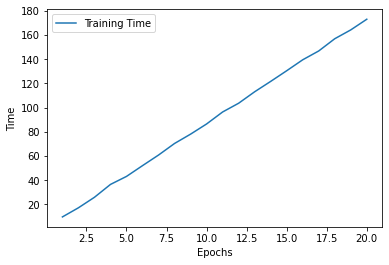

In [10]:
#Plot Epochs vs Training Time

plt.plot(x, time_list, label='Training Time')
plt.xlabel('Epochs')
plt.ylabel('Time')
plt.legend()
plt.show()

## **Linear Regression Using PyTorch**

In [11]:
# imports
from sklearn import preprocessing
import torch, torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.nn import Module
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import os

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/likarajo/petrol_consumption/master/data/petrol_consumption.csv')

In [13]:
petrol_cons=(df-df.mean())/df.std()
petrol_cons.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,1.40062,-1.169466,-1.028042,-0.817255,-0.319708
1,1.40062,-0.261205,-1.235975,0.030046,-0.471649
2,1.40062,-0.656935,-1.139742,0.174268,-0.140955
3,-0.17705,1.095085,-0.920639,-0.745144,-1.454794
4,0.34884,0.273989,-1.470545,-0.474729,-1.490545


In [14]:
x = petrol_cons.iloc[:, 0:4].values
y = petrol_cons.iloc[:, 4].values

In [15]:
class LinearRegression(nn.Module):
    def __init__(self,input_size,output_size):
        super(LinearRegression,self).__init__()
        self.linear = nn.Linear(input_size,output_size)

    def forward(self,x):
        out = self.linear(x) #Forward propogation 
        return out

In [16]:
model = LinearRegression(4,1)

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.002)
num_epochs = 10

In [18]:
# Create PyTorch Tensors from Numpy arrays
inputs = torch.from_numpy(x).float()
targets = torch.from_numpy(y).float()

In [19]:
dataset = torch.utils.data.TensorDataset(inputs, targets)

In [20]:
val_percent = 0.1
num_rows = len(petrol_cons)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size]) # split dataset into 2 parts of the desired length

In [21]:
batch_size = 50
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [22]:
for xb, yb in val_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[-1.1447, -0.7668,  0.6497,  1.0576],
        [ 0.3488,  0.3577,  0.8625, -0.7451],
        [-0.7029,  0.1799, -0.4756,  1.8328],
        [-0.7029, -0.9132, -0.2407, -0.5468]])
targets: tensor([ 0.6009, -1.0079,  3.4967,  1.2265])


In [34]:
#Define model
model = torch.nn.Linear(4,1)

#Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-2)

# Import nn.functional
import torch.nn.functional as F

#Define loss function
loss_fn = torch.nn.MSELoss() 

#Define a utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
    mse = []
    val_mse = []
    for epoch in range(num_epochs):
        for xb,yb in train_loader:
            #Generate predictions
            pred = model(xb)
            loss = loss_fn(pred,yb)
            mse.append(loss.item())
            
            #Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()

        for xb,yb in val_loader:
            #Generate predictions
            pred2 = model(xb)
            loss2 = loss_fn(pred2,yb)
            val_mse.append(loss2.item())
          
        print(f'Epoch:{epoch+1}/{num_epochs} | MSE:{loss.item()}')
    
    return mse, val_mse

#Train the model for 100 epochs
history = fit(100, model, loss_fn, opt)

#Generate predictions
#preds = model(inputs)

Epoch:1/100 | MSE:1.3111674785614014
Epoch:2/100 | MSE:1.2903167009353638
Epoch:3/100 | MSE:1.2702161073684692
Epoch:4/100 | MSE:1.2508379220962524
Epoch:5/100 | MSE:1.2321555614471436
Epoch:6/100 | MSE:1.2141432762145996
Epoch:7/100 | MSE:1.1967766284942627
Epoch:8/100 | MSE:1.1800317764282227
Epoch:9/100 | MSE:1.1638860702514648
Epoch:10/100 | MSE:1.148317575454712
Epoch:11/100 | MSE:1.1333049535751343
Epoch:12/100 | MSE:1.118828296661377
Epoch:13/100 | MSE:1.1048673391342163
Epoch:14/100 | MSE:1.0914040803909302
Epoch:15/100 | MSE:1.078419804573059
Epoch:16/100 | MSE:1.0658973455429077
Epoch:17/100 | MSE:1.0538197755813599
Epoch:18/100 | MSE:1.0421710014343262
Epoch:19/100 | MSE:1.0309354066848755
Epoch:20/100 | MSE:1.0200978517532349
Epoch:21/100 | MSE:1.0096442699432373
Epoch:22/100 | MSE:0.999560534954071
Epoch:23/100 | MSE:0.9898332953453064
Epoch:24/100 | MSE:0.9804494976997375
Epoch:25/100 | MSE:0.9713971018791199
Epoch:26/100 | MSE:0.9626638889312744
Epoch:27/100 | MSE:0.9542

In [33]:
max_epochs = 31             #Run for a maximum of 30 epochs

import time
time_list = []              #Contains time taken to execute Neural Network of n epochs
mse = []                    #Contains Training MSE of the neural network
val_mse = []           #Contains Validation MSE of the neural network

#model = MnistModel(784,10)

for epoch in range(1,max_epochs):
  start = time.time()
  history = fit(epoch, model, loss_fn, opt)
  end = time.time()
  time_list.append(end-start)
  mse.append( sum(history[0]) / len(history[0]) )
  val_mse.append( sum(history[1]) / len(history[1]) )

Epoch:1/1 | MSE:1.2410212755203247
Epoch:1/2 | MSE:1.2181875705718994
Epoch:2/2 | MSE:1.196427583694458
Epoch:1/3 | MSE:1.1756871938705444
Epoch:2/3 | MSE:1.1559149026870728
Epoch:3/3 | MSE:1.137062668800354
Epoch:1/4 | MSE:1.1190840005874634
Epoch:2/4 | MSE:1.101935625076294
Epoch:3/4 | MSE:1.0855762958526611
Epoch:4/4 | MSE:1.0699669122695923
Epoch:1/5 | MSE:1.0550707578659058
Epoch:2/5 | MSE:1.040852427482605
Epoch:3/5 | MSE:1.0272789001464844
Epoch:4/5 | MSE:1.0143187046051025
Epoch:5/5 | MSE:1.0019419193267822
Epoch:1/6 | MSE:0.9901206493377686
Epoch:2/6 | MSE:0.9788275957107544
Epoch:3/6 | MSE:0.968037486076355
Epoch:4/6 | MSE:0.9577264189720154
Epoch:5/6 | MSE:0.9478713274002075
Epoch:6/6 | MSE:0.9384504556655884
Epoch:1/7 | MSE:0.9294434189796448
Epoch:2/7 | MSE:0.9208305478096008
Epoch:3/7 | MSE:0.9125931859016418
Epoch:4/7 | MSE:0.9047138094902039
Epoch:5/7 | MSE:0.8971756100654602
Epoch:6/7 | MSE:0.8899626135826111
Epoch:7/7 | MSE:0.8830599188804626
Epoch:1/8 | MSE:0.8764531

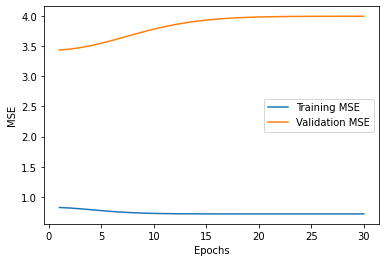

In [30]:
#Plot Epochs vs Accuracy

x = np.arange(1, max_epochs)
plt.plot(x, np.array(mse), label='Training MSE')
plt.plot(x, np.array(val_mse), label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

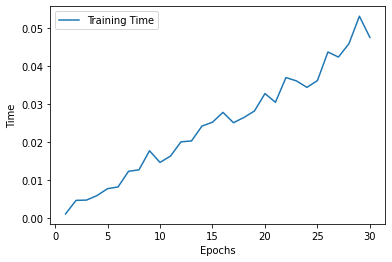

In [27]:
#Plot Epochs vs Training Time

plt.plot(x, time_list, label='Training Time')
plt.xlabel('Epochs')
plt.ylabel('Time')
plt.legend()
plt.show()